In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from scipy.stats import pearsonr, spearmanr, kendalltau, fisher_exact, ttest_ind, sem, binom
from helpers import plot_params
from natsort import natsorted, natsort_keygen

## Load data

In [2]:
# Human data from Gerstenberg
humans = pyreadr.read_r('data/trackingDataFrames.RData')['df.judgments']
counterfactual = humans[humans.condition == "counterfactual"]
outcome = humans[humans.condition == "outcome"]
outcome.head()

,condition,participant,sex,age,time,trial,clip,index,outcome,outcome.actual,outcome.counterfactual,rating
520,outcome,12.0,male,53.0,13.977862,13.0,1.0,1,0.0,miss,miss,99.634766
521,outcome,12.0,male,53.0,13.977862,14.0,2.0,2,0.0,miss,miss,99.232422
522,outcome,12.0,male,53.0,13.977862,4.0,3.0,1,0.0,miss,close,99.232422
523,outcome,12.0,male,53.0,13.977862,15.0,4.0,2,0.0,miss,close,99.968099
524,outcome,12.0,male,53.0,13.977862,11.0,5.0,1,0.0,miss,hit,99.266927


In [3]:
# Model data we collected
models = pd.read_csv("data/MICHOTTE_RESULTS_REV2.csv")
models.head()

,SEQ,COND,FUYU,OTTER,ADAPTER,GPT-4V,CLAUDE-3
0,1,color,pink,NaN,white,white,white
1,2,color,pink,white,blue,white,white
2,3,color,pink,black,white,white,white
3,4,color,pink,white,blue,white,white
4,5,color,pink,white,white,white,white


### 1. Analyze match to ground truth for color test

In [4]:
# Define subjects
subjects = ["FUYU", "OTTER", "ADAPTER", "GPT-4V", "CLAUDE-3"]
colors = np.zeros(len(subjects))
colors_errs = np.zeros(len(subjects))

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # Absolute distance to ground truth and absolute distance to human average
        correct = sum(models[models.COND == "color"][subject] == "white")
        colors[ind] = (correct / 18)*100
        colors_errs[ind] = binom.std(100, correct / 18)
        print(f"Color, {subject}: {colors[ind]:.4f} %")

Color, FUYU: 0.0000 %
Color, OTTER: 55.5556 %
Color, ADAPTER: 77.7778 %
Color, GPT-4V: 100.0000 %
Color, CLAUDE-3: 100.0000 %


### 2. Analyze visual understanding test with trajectories

In [5]:
trajectory = np.zeros(len(subjects))
trajectory_errs = np.zeros(len(subjects))

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # Absolute distance to ground truth and absolute distance to human average
        correct = sum(models[models.COND == "trajectory"][subject] == "right to left")
        trajectory[ind] = (correct / 18)*100
        trajectory_errs[ind] = binom.std(100, correct / 18)
        print(f"Trajectory, {subject}: {trajectory[ind]:.4f} %")

Trajectory, FUYU: 0.0000 %
Trajectory, OTTER: 72.2222 %
Trajectory, ADAPTER: 0.0000 %
Trajectory, GPT-4V: 50.0000 %
Trajectory, CLAUDE-3: 11.1111 %


### 3. Analyze correlation with human data for outcome condition

In [6]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index

num_humans = len(outcome.participant.unique())
num_seqs = 18
human_mean = outcome[outcome["clip"] < 19].groupby('clip').mean('rating')['rating'].values

for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    temp[:] = np.nan
    for ind, human in enumerate(outcome.participant.unique()):

        # If array for human to human comparison, save human mean. Otherwise, save model answers in first column.
        if model == "HUMAN":
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = human_mean
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.COND == "outcome"][model].values.astype(float)

        # Save individual human answers and individual human id
        ind_human = outcome[(outcome["participant"] == human) & (outcome["clip"] < 19)].sort_values("clip", key=natsort_keygen())
        temp[ind*num_seqs:(ind+1)*num_seqs, 1] = ind_human.rating.values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human
        
    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/03_michotte/{model}_outcome.csv")

FUYU, 0.2727
OTTER, 0.0163
ADAPTER, 0.0000
GPT-4V, 0.0520
CLAUDE-3, -0.1933
HUMAN, 0.5917


In [6]:
# Load
outcome_lmer = pd.read_csv('dataframes/03_michotte/03_outcome_lmer.csv')

# Separate coefficient and re-format CI
outcome_lmer_coef = outcome_lmer.iloc[:,0].values
outcome_lmer_conf = outcome_lmer.iloc[:,1:].values.T

### 4. Analyze correlation with human data for counterfactual condition

In [8]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index

num_humans = len(counterfactual.participant.unique())
num_seqs = 18
human_mean = counterfactual[counterfactual["clip"] < 19].groupby('clip').mean('rating')['rating'].values

for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    temp[:] = np.nan
    for ind, human in enumerate(counterfactual.participant.unique()):

        # If array for human to human comparison, save human mean. Otherwise, save model answers in first column.
        if model == "HUMAN":
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = human_mean
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.COND == "counterfactual"][model].values.astype(float)

        # Save individual human answers and individual human id
        ind_human = counterfactual[(counterfactual["participant"] == human) & (counterfactual["clip"] < 19)].sort_values("clip", key=natsort_keygen())
        temp[ind*num_seqs:(ind+1)*num_seqs, 1] = ind_human.rating.values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human
        
    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/03_michotte/{model}_counterfactual.csv")

FUYU, 0.3978
OTTER, -0.2197
ADAPTER, 0.0000
GPT-4V, nan
CLAUDE-3, -0.0730
HUMAN, 0.7668


/tmp/ipykernel_1547187/1232106037.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")


In [7]:
# Load
counterfactual_lmer = pd.read_csv('dataframes/03_michotte/03_counterfactual_lmer.csv')

# Separate coefficient and re-format CI
counterfactual_lmer_coef = counterfactual_lmer.iloc[:,0].values
counterfactual_lmer_conf = counterfactual_lmer.iloc[:,1:].values.T

## Make main plot
I imagine a plot with 4 panels, single row with four columns,  for every study
- A: Barplots model comparison for background color task. Bars show percentage correct.
- B: Counting model comparison as in A
- C: Reasoning ground truth comparison as in A
- D: Match to humans,  probably via regression coefficient.

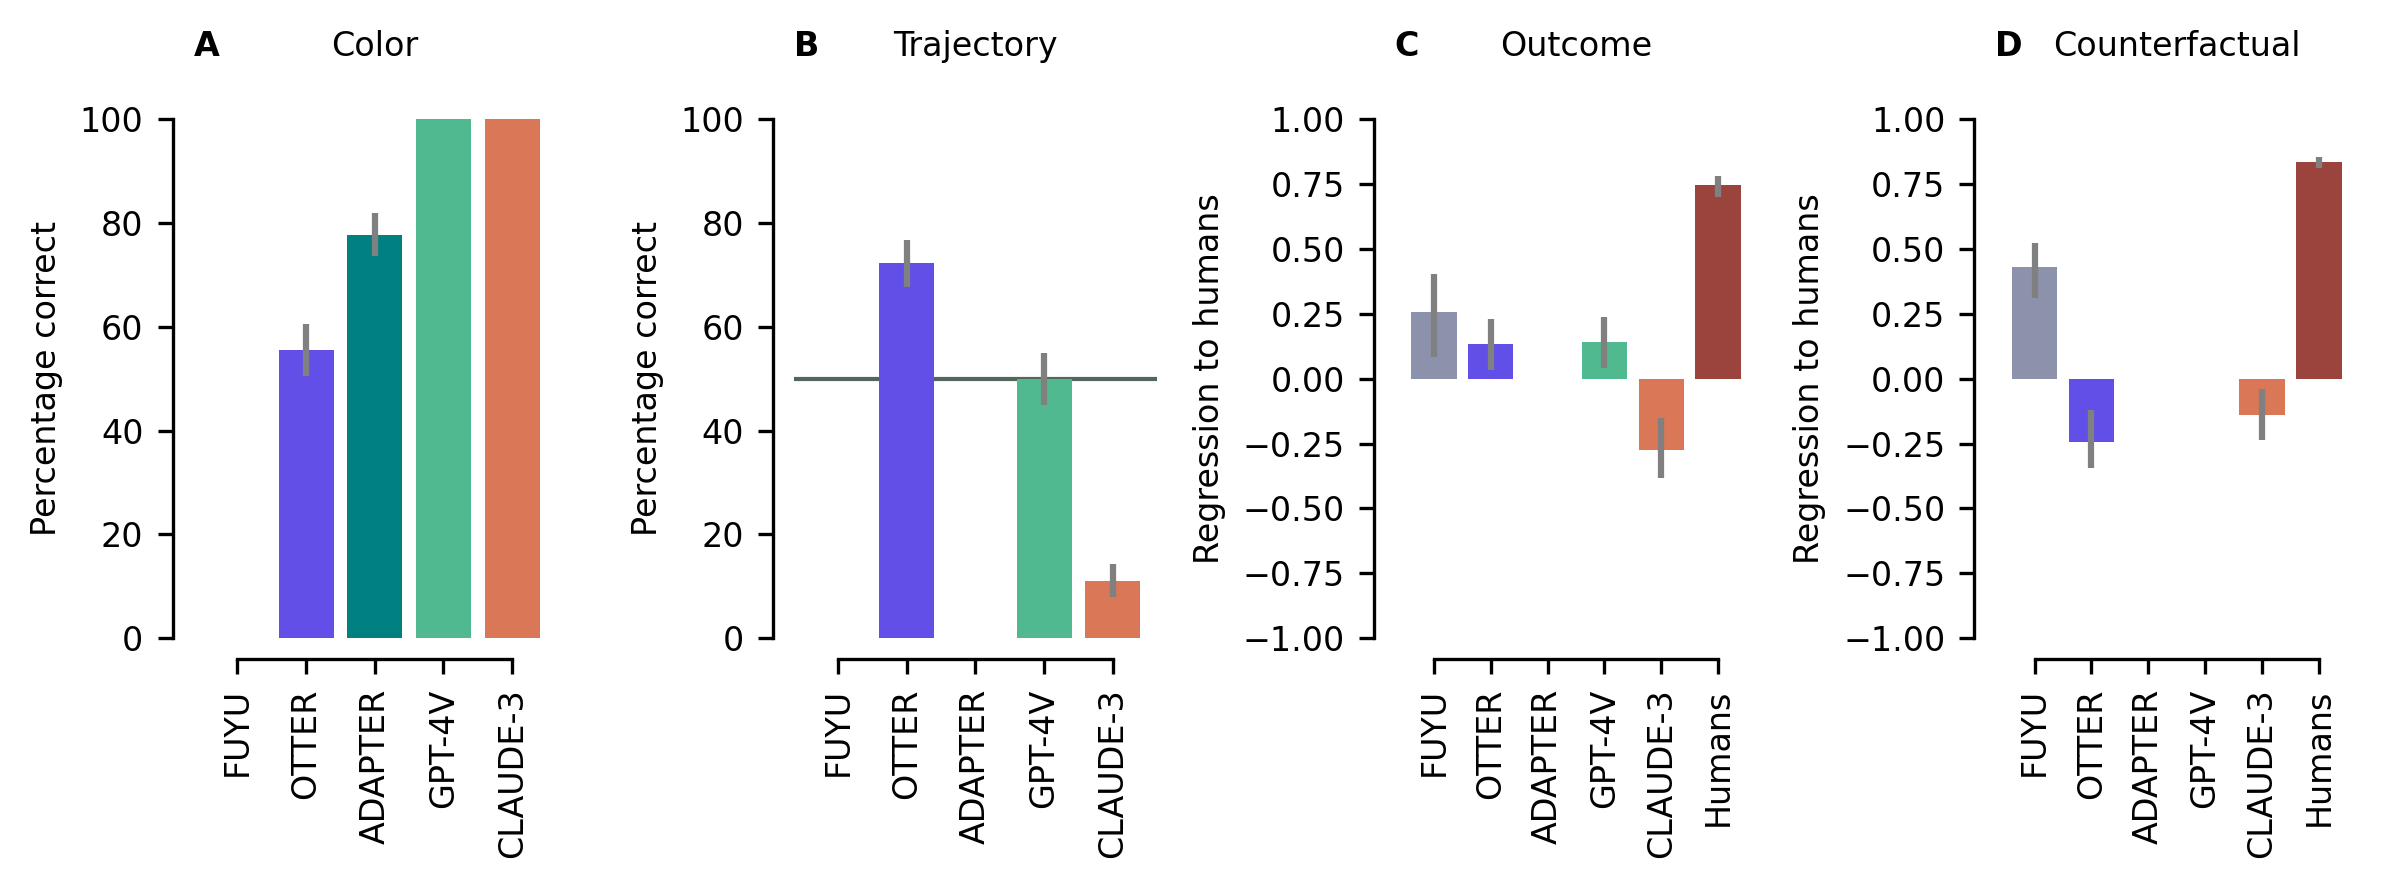

In [8]:
# Init plotting params
model_colors = plot_params()

# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 4, figsize=(8,3), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects), colors, color=model_colors)
axs[0].errorbar(np.arange(num_subjects), colors, colors_errs, ls="none", ecolor="gray")
axs[0].set_title("Color\n")
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Percentage correct")
axs[0].set_ylim(0, 100)
#axs[0].axhline(y=random_dists[0])
axs[0].set_xticks(np.arange(num_subjects))

# Plot B
axs[1].bar(np.arange(num_subjects), trajectory, color=model_colors)
axs[1].errorbar(np.arange(num_subjects), trajectory, trajectory_errs, ls="none", ecolor="gray")
axs[1].set_title("Trajectory\n")
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Percentage correct")
axs[1].set_ylim(0, 100)
axs[1].axhline(50, linewidth=1, zorder=0)
axs[1].set_xticks(np.arange(num_subjects))

# Plot C
axs[2].bar(np.arange(num_subjects+1), outcome_lmer_coef, color=model_colors)
axs[2].errorbar(np.arange(num_subjects+1), outcome_lmer_coef, yerr=outcome_lmer_conf, ls="none", ecolor="gray")
axs[2].set_title("Outcome\n", loc="center")
axs[2].set_title("C\n", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel("Regression to humans")
axs[2].set_ylim(-1, 1)
axs[2].set_xticks(np.arange(num_subjects+1))

# Plot D
axs[3].bar(np.arange(num_subjects+1), counterfactual_lmer_coef, color=model_colors)
axs[3].errorbar(np.arange(num_subjects+1), counterfactual_lmer_coef, yerr=counterfactual_lmer_conf, ls="none", ecolor="gray")
axs[3].set_title("Counterfactual\n", loc="center")
axs[3].set_title("D\n", fontweight='bold', loc='left', fontsize='medium')
axs[3].set_ylabel("Regression to humans")
axs[3].set_ylim(-1, 1)
axs[3].set_xticks(np.arange(num_subjects+1))

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(subjects, rotation=90)
axs[1].set_xticklabels(subjects, rotation=90)
axs[2].set_xticklabels(subjects + ["Humans"], rotation=90)
axs[3].set_xticklabels(subjects + ["Humans"], rotation=90)
plt.savefig("figures/03_michotte_main.pdf", dpi=300)

#### Additional: example plot for counterfactual condition

In [11]:
# Print images in order from easy to hard for humans 
human_mean = counterfactual[counterfactual["clip"] < 19].groupby('clip').mean('rating').rating
gpt4v = models[models.COND == "counterfactual"]["GPT-4V"]

# Sort ratings from low high (kind of like a confidence rating)
human_lowhigh = np.argsort(human_mean.values)
gpt4v_lowhigh = np.argsort(gpt4v.values)
print(human_lowhigh+1)

[13  8  2 14  7  1 10 16  3  4 15  9  6 11 12  5 17 18]


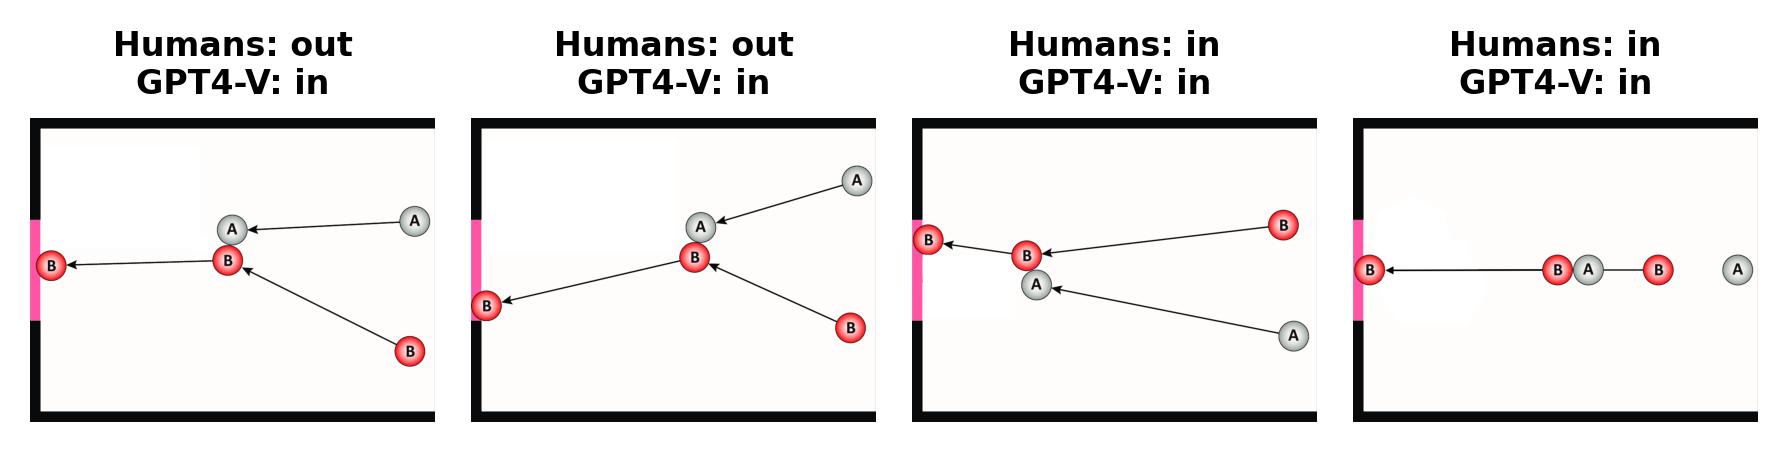

In [12]:
# Prepare plot
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: Humans say it doesnt go in, GPT says it goes in (13)
axs[0].imshow(plt.imread("eval/images/michotte_edit/clip_13.png"))
axs[0].axis("off")

# Second column: Humans say it doesnt go in, GPT says it goes in (8)
axs[1].imshow(plt.imread("eval/images/michotte_edit/clip_8.png"))
axs[1].axis("off")

# Third column: Humans say it goes in, GPT says it goes in (17)
axs[2].imshow(plt.imread("eval/images/michotte_edit/clip_17.png"))
axs[2].axis("off")

# Fourth column: Humans say it goes in, GPT says it goes in (18)
axs[3].imshow(plt.imread("eval/images/michotte_edit/clip_18.png"))
axs[3].axis("off")

# Set column titles
axs[0].set_title("Humans: out\nGPT4-V: in", fontweight="bold")
axs[1].set_title("Humans: out\nGPT4-V: in", fontweight="bold")
axs[2].set_title("Humans: in\nGPT4-V: in", fontweight="bold")
axs[3].set_title("Humans: in\nGPT4-V: in", fontweight="bold")
plt.savefig("figures/03_michotte_examples.pdf", dpi=300, bbox_inches='tight')